In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

In [11]:
prices = pd.read_csv('data/sample_prices.csv')
returns = prices.pct_change().dropna()

<AxesSubplot:>

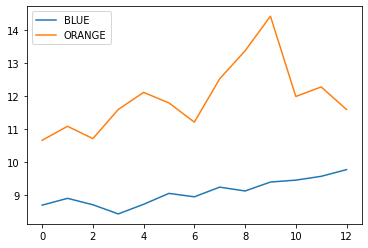

In [12]:
prices.plot()

<AxesSubplot:>

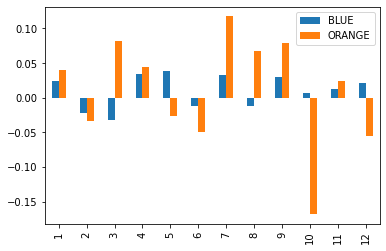

In [14]:
returns.plot.bar()

In [16]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

In [21]:
(((returns+1).prod()-1)*100).round(2)

BLUE      12.33
ORANGE     8.72
dtype: float64

In [30]:
returns = pd.read_csv('data/Portfolios_Formed_on_ME_monthly_EW.csv', 
                      header=0, index_col=0, parse_dates=True, na_values=-99.99)
cols = ['Lo 10', 'Hi 10']
returns = returns[cols]
returns = returns / 100
returns.columns = ['SmallCap', 'LargeCap']

In [31]:
returns.head()

,SmallCap,LargeCap
192607,-0.0145,0.0329
192608,0.0512,0.0370
192609,0.0093,0.0067
192610,-0.0484,-0.0243
192611,-0.0078,0.0270


<AxesSubplot:>

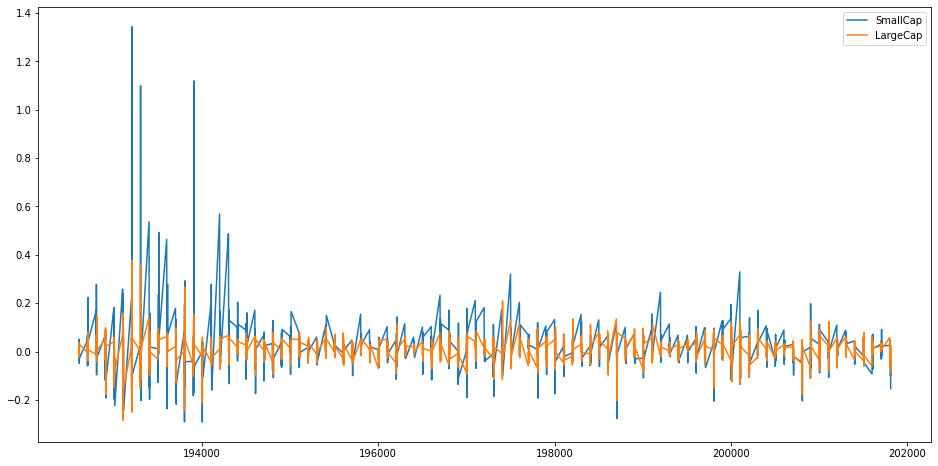

In [34]:
returns.plot(figsize=(16,8))

In [36]:
returns.std()

SmallCap    0.106288
LargeCap    0.053900
dtype: float64

In [41]:
annualized_vol = returns.std()*np.sqrt(12)
annualized_vol

SmallCap    0.368193
LargeCap    0.186716
dtype: float64

In [48]:
n_months = returns.shape[0]
return_per_month = (returns + 1).prod()**(1/n_months) - 1
return_per_month

SmallCap    0.012986
LargeCap    0.007423
dtype: float64

In [51]:
annualized_return = (return_per_month+1)**12 - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [54]:
annualized_return = (returns + 1).prod()**(12/n_months) - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [59]:
rf = .03
er = annualized_return - rf
sharpe_ratio = er/annualized_vol
sharpe_ratio

SmallCap    0.373346
LargeCap    0.336392
dtype: float64

In [64]:
returns.index = pd.to_datetime(returns.index, format='%Y%m')

In [68]:
returns.index = returns.index.to_period('M')

AttributeError: 'PeriodIndex' object has no attribute 'to_period'

In [89]:
import edhec_risk_kit as erk


erk.get_ffme_returns()

,SmallCap,LargeCap
1926-07,-0.0145,0.0329
1926-08,0.0512,0.0370
1926-09,0.0093,0.0067
1926-10,-0.0484,-0.0243
1926-11,-0.0078,0.0270
...,...,...
2018-08,0.0241,0.0234
2018-09,-0.0168,0.0087
2018-10,-0.1002,-0.0657
2018-11,-0.0365,0.0253


In [91]:
erk.hi()

'hi'

In [1]:
import ipywidgets as widgets

In [2]:
def squareit(n):
    return n*n

widgets.interact(squareit, n = (0,100))

interactive(children=(IntSlider(value=50, description='n'), Output()), _dom_classes=('widget-interact',))

<function __main__.squareit(n)>

In [51]:
risky_r = pd.DataFrame(pd.read_csv('btcusd_daily.csv').price.pct_change().dropna())
# risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = .00013 # fast way to set all values to a number
start = 1 # start at $1000
floor = 0.70 # set the floor to 80 percent of the starting value

# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
peak = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
for step in range(n_steps):
    peak = np.maximum(account_value, peak)
    floor_value = peak * floor
    
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
#     floor_history.iloc[step] = floor_value

<AxesSubplot:>

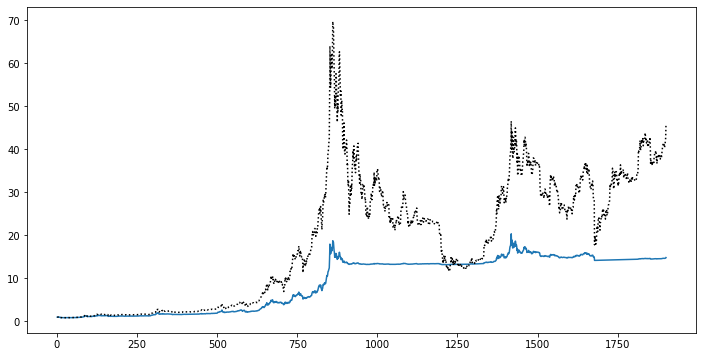

In [52]:
risky_wealth = start*(1+risky_r).cumprod()
ax = account_history["price"].plot(figsize=(12,6))
risky_wealth["price"].plot(ax=ax, style="k:")